In [5]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import pickle
import sys

In [6]:
sys.path.append("..")

In [7]:
from functions.sampling import sample_rows2

### Load and trim data

In [8]:
dfx = pd.read_pickle("../datasets/training_data-X_values.pkl")
dfy = pd.read_pickle("../datasets/training_data-y_value.pkl")

In [9]:
#dfx.info()  #All float64 12.5GB

In [10]:
dtypes = {
        'flow_duration': np.float32,
        'Header_Length': np.uint32,
        'Protocol Type': str,
        'Duration': np.float32,
        'Rate': np.uint32,
        'Srate': np.uint32,
        'Drate': np.float32,
        'fin_flag_number': np.bool_,
        'syn_flag_number': np.bool_,
        'rst_flag_number': np.bool_,
        'psh_flag_number': np.bool_,
        'ack_flag_number': np.bool_,
        'ece_flag_number': np.bool_,
        'cwr_flag_number': np.bool_,
        'ack_count': np.float16,
        'syn_count': np.float16,
        'fin_count': np.uint16,
        'urg_count': np.uint16, 
        'rst_count': np.uint16, 
        'HTTP': np.bool_, 
        'HTTPS': np.bool_, 
        'DNS': np.bool_, 
        'Telnet': np.bool_,
        'SMTP': np.bool_, 
        'SSH': np.bool_, 
        'IRC': np.bool_, 
        'TCP': np.bool_, 
        'UDP': np.bool_, 
        'DHCP': np.bool_, 
        'ARP': np.bool_, 
        'ICMP': np.bool_, 
        'IPv': np.bool_, 
        'LLC': np.bool_,
        'Tot sum': np.float32, 
        'Min': np.float32, 
        'Max': np.float32, 
        'AVG': np.float32, 
        'Std': np.float32, 
        'Tot size': np.float32, 
        'IAT': np.float32, 
        'Number': np.float32,
        'Magnitue': np.float32, 
        'Radius': np.float32, 
        'Covariance': np.float32, 
        'Variance': np.float32, 
        'Weight': np.float32
}

def convert_dtype(df):
    #adjust data type
    for col, typ in dtypes.items():
        df[col] = df[col].astype(typ)

    #format columns names to lowercase
    df.columns = df.columns.str.lower().str.replace(' ','_')
    return df

In [11]:
dfx = convert_dtype(dfx)

In [12]:
# dfx.info()  # dtypes: bool(21), float16(2), float32(16), object(1), uint16(3), uint32(3)/ 3.9+ GB

In [13]:
dfy.info()

<class 'pandas.core.series.Series'>
RangeIndex: 36346418 entries, 0 to 36346417
Series name: label
Non-Null Count     Dtype 
--------------     ----- 
36346418 non-null  object
dtypes: object(1)
memory usage: 277.3+ MB


### Sampling Rows

Large amount data is hard to process, this function ensures that the resulting DataFrame contains a balanced representation of each class while reducing the overall number of rows based on the specified percentage.

In [14]:
dfx_s, dfy_s = sample_rows2(dfx, dfy, percent_rows=0.1)

In [15]:
dfy_s.info()

<class 'pandas.core.series.Series'>
RangeIndex: 3634643 entries, 0 to 3634642
Series name: label
Non-Null Count    Dtype 
--------------    ----- 
3634643 non-null  object
dtypes: object(1)
memory usage: 27.7+ MB


In [16]:
df = pd.concat([dfx_s, dfy_s], axis=1)

In [32]:
dfx_test = pd.read_pickle('../datasets/test_data-X_values.pkl')
dfx_test = convert_dtype(dfx_test)
dfy_test = pd.read_pickle('../datasets/test_data-y_value.pkl')
df_test = pd.concat([dfx_test, dfy_test], axis=1)

### Group attacks

In [17]:
# Show the number of unique values in the y_column
print('Unique values in y_column: {}'.format(len(df['label'].unique())))

print(df['label'].unique())
attack_labels = df['label'].unique()

Unique values in y_column: 34
['DDoS-SynonymousIP_Flood' 'DDoS-PSHACK_Flood' 'DoS-UDP_Flood'
 'DDoS-TCP_Flood' 'DDoS-UDP_Flood' 'DDoS-RSTFINFlood' 'DoS-TCP_Flood'
 'DDoS-SYN_Flood' 'Mirai-greeth_flood' 'DoS-SYN_Flood' 'BenignTraffic'
 'DDoS-ICMP_Flood' 'Mirai-greip_flood' 'DNS_Spoofing' 'Mirai-udpplain'
 'DDoS-UDP_Fragmentation' 'DDoS-ACK_Fragmentation' 'DoS-HTTP_Flood'
 'DDoS-HTTP_Flood' 'MITM-ArpSpoofing' 'DDoS-ICMP_Fragmentation'
 'Recon-HostDiscovery' 'Recon-OSScan' 'Recon-PortScan' 'VulnerabilityScan'
 'SqlInjection' 'DDoS-SlowLoris' 'CommandInjection' 'Uploading_Attack'
 'DictionaryBruteForce' 'XSS' 'BrowserHijacking' 'Recon-PingSweep'
 'Backdoor_Malware']


In [18]:
dict_8_classes = { 'BenignTraffic': 'Benign',   
                    'DDoS-RSTFINFlood': 'DDoS', 'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS', 
                    'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS', 'DDoS-ICMP_Flood': 'DDoS', 
                    'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS', 
                    'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS', 
                    'DDoS-SlowLoris': 'DDoS', 'DDoS-HTTP_Flood': 'DDoS', 'DoS-UDP_Flood': 'DoS', 
                    'DoS-SYN_Flood': 'DoS', 'DoS-TCP_Flood': 'DoS', 'DoS-HTTP_Flood': 'DoS', 
                    'Mirai-greeth_flood': 'Mirai', 'Mirai-greip_flood': 'Mirai', 'Mirai-udpplain': 'Mirai', 
                    'Recon-PingSweep': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PortScan': 'Recon', 
                    'VulnerabilityScan': 'Recon', 'Recon-HostDiscovery': 'Recon', 'DNS_Spoofing': 'Spoofing', 
                    'MITM-ArpSpoofing': 'Spoofing', 'BrowserHijacking': 'Web', 
                    'Backdoor_Malware': 'Web', 'XSS': 'Web', 'Uploading_Attack': 'Web', 'SqlInjection': 'Web', 
                    'CommandInjection': 'Web', 'DictionaryBruteForce': 'BruteForce'}                                                                                                                 # Brute Force 
                                                                                                                                 # Brute Force

dict_2_classes = { 'BenignTraffic': 'Benign',   
                    'DDoS-RSTFINFlood': 'Malicious', 'DDoS-PSHACK_Flood': 'Malicious', 'DDoS-SYN_Flood': 'Malicious', 
                    'DDoS-UDP_Flood': 'Malicious', 'DDoS-TCP_Flood': 'Malicious', 'DDoS-ICMP_Flood': 'Malicious', 
                    'DDoS-SynonymousIP_Flood': 'Malicious', 'DDoS-ACK_Fragmentation': 'Malicious', 
                    'DDoS-UDP_Fragmentation': 'Malicious', 'DDoS-ICMP_Fragmentation': 'Malicious', 
                    'DDoS-SlowLoris': 'Malicious', 'DDoS-HTTP_Flood': 'Malicious', 'DoS-UDP_Flood': 'Malicious', 
                    'DoS-SYN_Flood': 'Malicious', 'DoS-TCP_Flood': 'Malicious', 'DoS-HTTP_Flood': 'Malicious', 
                    'Mirai-greeth_flood': 'Malicious', 'Mirai-greip_flood': 'Malicious', 'Mirai-udpplain': 'Malicious', 
                    'Recon-PingSweep': 'Malicious', 'Recon-OSScan': 'Malicious', 'Recon-PortScan': 'Malicious', 
                    'VulnerabilityScan': 'Malicious', 'Recon-HostDiscovery': 'Malicious', 'DNS_Spoofing': 'Malicious', 
                    'MITM-ArpSpoofing': 'Malicious', 'BrowserHijacking': 'Malicious', 
                    'Backdoor_Malware': 'Malicious', 'XSS': 'Malicious', 'Uploading_Attack': 'Malicious', 'SqlInjection': 'Malicious', 
                    'CommandInjection': 'Malicious', 'DictionaryBruteForce': 'Malicious'}                                                                                                                                      # Brute Force

In [19]:
df_34 = df.copy()
df_8 = df_34.copy()
df_8['label'] = df_8['label'].map(dict_8_classes)
df_2 = df_34.copy()
df_2['label'] = df_2['label'].map(dict_2_classes)

In [34]:
df_34_test = df_test.copy()
df_8_test = df_34_test.copy()
df_8_test['label'] = df_8_test['label'].map(dict_8_classes)
df_2_test = df_34_test.copy()
df_2_test['label'] = df_2_test['label'].map(dict_2_classes)

In [36]:
path = '../datasets/'

df_34.to_csv(path + 'df_34.csv', index=False)
df_8.to_csv(path + 'df_8.csv', index=False)
df_2.to_csv(path + 'df_2.csv', index=False)

df_34_test.to_csv(path + 'df_34_test.csv', index=False)
df_8_test.to_csv(path + 'df_8_test.csv', index=False)
df_2_test.to_csv(path + 'df_2_test.csv', index=False)

In [21]:
#df_8['label'].unique() #['DoS', 'DDoS', 'Recon', 'Mirai', 'Benign', 'Spoofing', 'Web', 'BruteForce']
#df_2['label'].unique() #['Malicious', 'Benign']

In [22]:
df_8.head()

,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,...,std,tot_size,iat,number,magnitue,radius,covariance,variance,weight,label
0,0.330794,82,6.0,64.0,3,3,0.0,False,True,False,...,0.0,54.0,83361056.0,9.5,10.392304,0.0,0.0,0.0,141.550003,DDoS
1,0.000000,54,6.0,64.0,26,26,0.0,False,False,False,...,0.0,54.0,83331792.0,9.5,10.392304,0.0,0.0,0.0,141.550003,DDoS
2,0.008145,11075,17.0,64.0,27092,27092,0.0,False,False,False,...,0.0,50.0,83016552.0,9.5,10.000000,0.0,0.0,0.0,141.550003,DoS
3,0.000000,54,6.0,64.0,99,99,0.0,False,False,False,...,0.0,54.0,83075968.0,9.5,10.392304,0.0,0.0,0.0,141.550003,DDoS
4,0.032477,16854,17.0,64.0,13547,13547,0.0,False,False,False,...,0.0,50.0,83106920.0,9.5,10.000000,0.0,0.0,0.0,141.550003,DDoS


### Analysis of attack class distribution

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

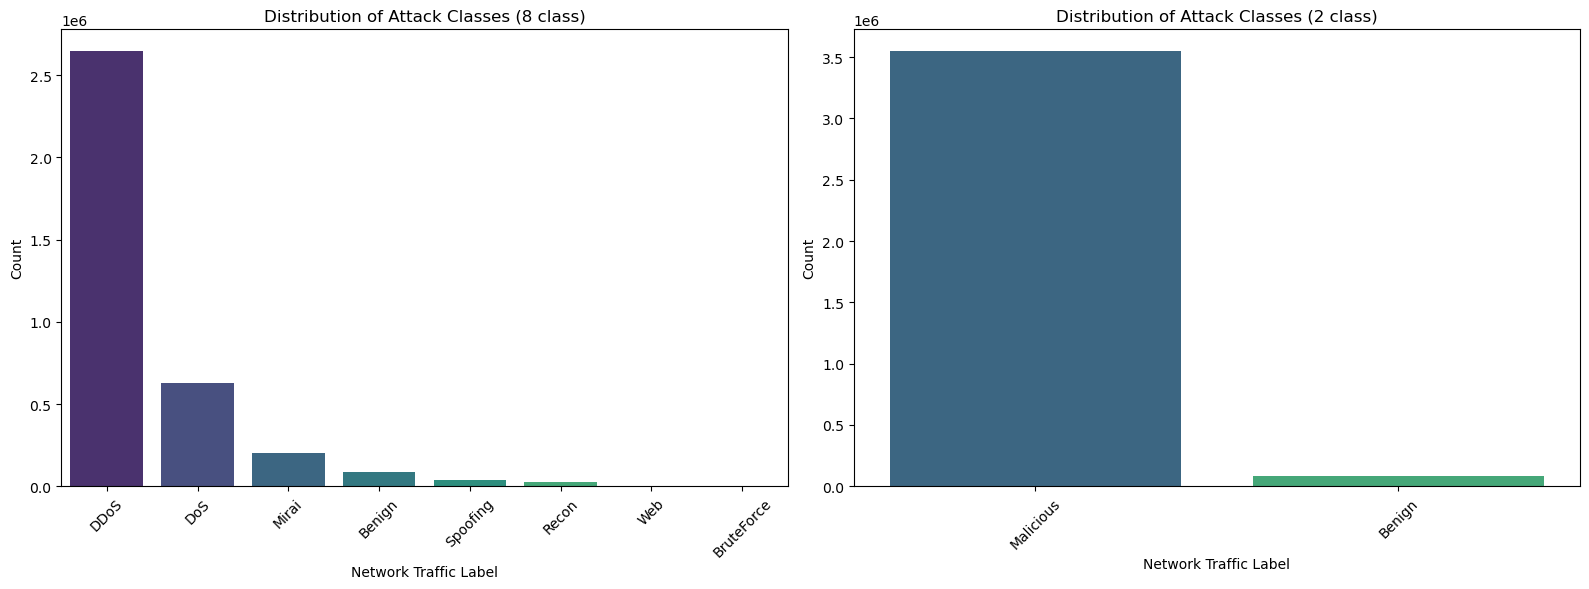

In [24]:
# Calculate value counts for df_8 and df_2
cnts8 = df_8['label'].value_counts()
cnts2 = df_2['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first chart
sns.barplot(x=cnts8.index, y=cnts8.values, palette='viridis', ax=axs[0]) 
axs[0].set_title('Distribution of Attack Classes (8 class)')
axs[0].set_xlabel('Network Traffic Label')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=45)

# Plot the second chart
sns.barplot(x=cnts2.index, y=cnts2.values, palette='viridis', ax=axs[1]) 
axs[1].set_title('Distribution of Attack Classes (2 class)')
axs[1].set_xlabel('Network Traffic Label')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'flow_duration')

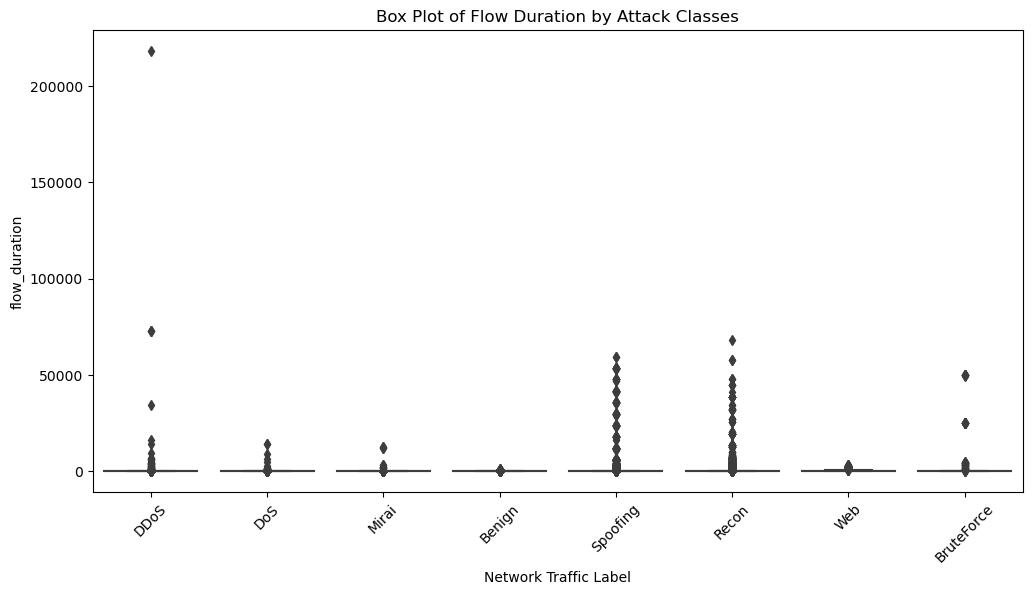

In [25]:
# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='flow_duration', data=df_8)
plt.xticks(rotation=45)
plt.title('Box Plot of Flow Duration by Attack Classes')
plt.xlabel('Network Traffic Label')
plt.ylabel('flow_duration')

d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


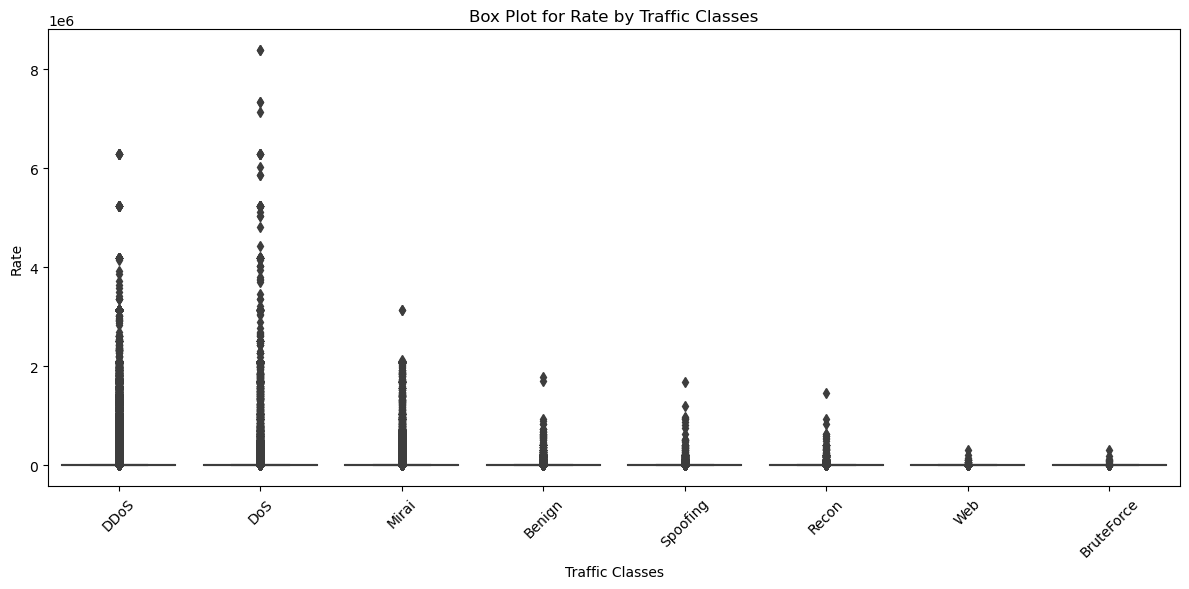

In [26]:
# Create a box plot for all labels
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_8, x="label", y="rate")  # You can specify a different palette if needed
plt.title('Box Plot for Rate by Traffic Classes')
plt.xlabel('Traffic Classes')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.tight_layout()